In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## for feature slection

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
dataset=pd.read_csv('train_norm.csv')
test_dataset=pd.read_csv('predicted_test_pet.csv')

In [3]:
dataset.head()

,pet_id,condition,color_type,length(m),X1,X2,breed_category,pet_category,issue_date_dt,listing_date_dt,date_diff,conditionnan,height(m),color_type_encode
0,ANSL_69903,0.666667,Brown Tabby,0.80,0.684211,1.000000,0.0,1,2016-07-10,2016-09-21,0.006719,0.0,0.061778,0.181818
1,ANSL_66892,0.333333,White,0.72,0.684211,1.000000,0.0,2,2013-11-21,2018-12-27,0.229314,0.0,0.204222,0.490909
2,ANSL_69750,1.000000,Brown,0.15,0.789474,0.444444,2.0,4,2014-09-28,2016-10-19,0.091203,1.0,0.797778,0.963636
3,ANSL_71623,0.333333,White,0.62,0.000000,0.111111,0.0,2,2016-12-31,2019-01-25,0.091576,0.0,0.284889,0.490909
4,ANSL_57969,0.666667,Black,0.50,0.947368,0.444444,0.0,1,2017-09-28,2017-11-19,0.004106,0.0,0.134667,0.472727


In [4]:
y_train=dataset[['pet_category', 'breed_category']]

In [5]:
X_train_first = dataset.copy()
X_test_first = test_dataset.copy()

In [6]:
pet_category_encode = X_train_first.groupby(['pet_category'])['breed_category'].mean().sort_values().index
pet_category_encode = {k:i for i,k in enumerate(pet_category_encode,0)}
X_train_first['pet_category'] = X_train_first['pet_category'].map(pet_category_encode)

X_test_first['pet_category'] = X_test_first['pet_category'].map(pet_category_encode)

In [7]:
num_features=[feature for feature in X_train_first.columns if X_train_first[feature].dtypes!='O' and feature != 'pet_category' and feature != 'breed_category']

for feature in num_features:
    X_train_first[feature]=(X_train_first[feature]-X_train_first[feature].min())/(X_train_first[feature].max()-X_train_first[feature].min())

In [8]:
X_train_first = X_train_first.drop(['pet_id', 'breed_category', 'color_type', 'issue_date_dt', 'listing_date_dt'],axis=1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_first, y_train, test_size=0.30, random_state=42)

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [11]:
xgb_model_breed = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
xgb_model_breed.fit(X_train, y_train['breed_category'])

y_pred = xgb_model_breed.predict(X_train)

print(confusion_matrix(y_train['breed_category'], y_pred))

s22 = f1_score(y_train['breed_category'], y_pred, average='weighted')

y_val_pred = xgb_model_breed.predict(X_val)
s22_val = f1_score(y_val['breed_category'], y_val_pred, average='weighted')

s22, s22_val

[[5923  363    0]
 [ 613 5265    0]
 [   0    0 1018]]


(0.9258770848661204, 0.9002869947905946)

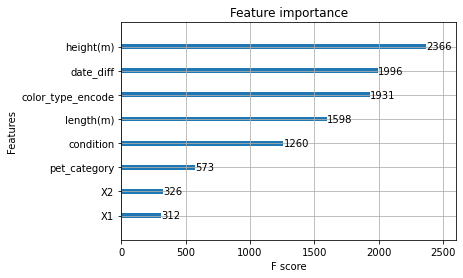

In [13]:
from xgboost import plot_importance
plot_importance(xgb_model_breed, )

In [14]:
y_pred_test = xgb_model_breed.predict(X_test_first[X_train.columns])

In [15]:
test_dataset['breed_category'] = y_pred_test

In [16]:
sub = test_dataset[['pet_id', 'breed_category', 'pet_category']]

In [17]:
sub.to_csv('C:/Pet-Adoption/submission.csv', index=False)

In [18]:
sub

,pet_id,breed_category,pet_category
0,ANSL_75005,1.0,2
1,ANSL_76663,0.0,1
2,ANSL_58259,0.0,2
3,ANSL_67171,0.0,2
4,ANSL_72871,0.0,2
...,...,...,...
8067,ANSL_66809,1.0,2
8068,ANSL_59041,1.0,2
8069,ANSL_60034,1.0,2
8070,ANSL_58066,2.0,4
